In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
import numpy as np
import glob
import random
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.font_manager import FontProperties
import japanize_matplotlib
import math
from sklearn import preprocessing

In [2]:
batch_size = 32
epochs = 500
interval = 10
allow_recognized = 5
latent_dim = 64

In [3]:
kkanji_path = './processed_data/kuzushiji/'
mkanji_path = './processed_data/etl9b/'
kkanji_classes = glob.glob(kkanji_path + '/*')
mkanji_classes = glob.glob(mkanji_path + '/*')

In [4]:
while True:
    print('Type the target character')
    s = input()

    uni_s = 'U+' + hex(ord(s))[2:].upper()
    jis_s = (hex(s.encode("iso-2022-jp")[3])[2:]+hex(s.encode("iso-2022-jp")[4])[2:])

    if (kkanji_path + uni_s in kkanji_classes) and (mkanji_path + jis_s in mkanji_classes):
        print('let\'s go with ' + s)
        print("Unicode：" + uni_s)
        print("JIS code：" + jis_s)
        break
    else:
        print('We can\'t handle that character. Plese type another one')

Type the target character
行
let's go with 行
Unicode：U+884C
JIS code：3954


In [5]:
kkanji_imgs = glob.glob(kkanji_path + uni_s + '/*')
mkanji_imgs = glob.glob(mkanji_path + jis_s + '/*') 

kkanji_imgs.sort()
mkanji_imgs.sort()
random.shuffle(kkanji_imgs)
random.shuffle(mkanji_imgs)

k_size = len(kkanji_imgs)
k_val_size = int(k_size * 0.2)

if k_val_size < 2:
    print('Sorry we cannot treat this class. Please set another class')
elif k_val_size > 10:
    k_val_print_size = 10
else:
    k_val_print_size = k_val_size
    
kkanji_imgs_train = kkanji_imgs[k_val_size:] # some images are used as test images.
kkanji_imgs_test = kkanji_imgs[:k_val_size]

kkanji_img_size = len(kkanji_imgs_train)
mkanji_img_size = len(mkanji_imgs)
img_size = kkanji_img_size + mkanji_img_size

print('== train ==')
print('amount of train kuzushiji images : ' + str(kkanji_img_size))
print('amount of train modern japanese images : ' + str(mkanji_img_size))
print('sum of train images : ' + str(img_size))
print('== test ==')
print('amount of test kuzushiji images : ' + str(len(kkanji_imgs_test)))

== train ==
amount of train kuzushiji images : 791
amount of train modern japanese images : 201
sum of train images : 992
== test ==
amount of test kuzushiji images : 197


In [6]:
# pre process
kkanji_data = np.zeros((kkanji_img_size, 64, 64))
mkanji_data = np.zeros((mkanji_img_size, 64, 64))
kkanji_labels = []
mkanji_labels = []

kkanji_count = 0
for img in kkanji_imgs_train:
    data = cv2.imread(img, 0)
    data = cv2.resize(data, (64, 64), interpolation = cv2.INTER_CUBIC)
    kkanji_data[kkanji_count] = data
    kkanji_labels.append(0.)
    kkanji_count = kkanji_count + 1
    
mkanji_count = 0
for img in mkanji_imgs:
    data = cv2.imread(img, 0)
    data = cv2.resize(data, (64, 64), interpolation = cv2.INTER_CUBIC)
    mkanji_data[mkanji_count] = data
    mkanji_labels.append(1.)
    mkanji_count = mkanji_count + 1
    
# Normalization
kkanji_data = kkanji_data.astype('float32') / 255.
mkanji_data = mkanji_data.astype('float32') / 255.

x_train = np.concatenate([kkanji_data, mkanji_data], axis = 0)
x_train = x_train.reshape((img_size, 64, 64, 1))

labels = kkanji_labels + mkanji_labels
y_train = keras.utils.to_categorical(labels)

# shuffle
p = np.random.permutation(img_size)
x_train = x_train[p]
y_train = y_train[p]

# use list label data later
y_row_train = [0] * img_size
for i, seed in enumerate(p):    
    y_row_train[i] = labels[seed]

In [7]:
# define encoder
encoder_inputs = keras.Input(shape=(64, 64, 1))
x = layers.Conv2D(16, 4, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(32, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   272         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   8224        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 64)     32832       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [8]:
# define sampling layer
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
# define decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(1 * 1 * 1024, activation="relu")(latent_inputs)
x = layers.Reshape((1, 1, 1024))(x)
x = layers.Conv2DTranspose(128, 5, activation="relu", strides=2)(x)
x = layers.Conv2DTranspose(64, 5, activation="relu", strides=2)(x)
x = layers.Conv2DTranspose(32, 6, activation="relu", strides=2)(x)
decoder_outputs = layers.Conv2DTranspose(1, 6, activation="sigmoid", strides=2)(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

print(decoder.summary())

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              66560     
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 128)         3276928   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 13, 13, 64)        204864    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 30, 30, 32)        73760     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 64, 64, 1)         1153

In [10]:
# define VAE's metrics, loss and gradient
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction),axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

vae = VAE(encoder, decoder)

In [11]:
# complile and fit
vae.compile(optimizer = keras.optimizers.Adam(), run_eagerly=True)

early_stopping =  keras.callbacks.EarlyStopping(monitor = 'total_loss', min_delta = 0.0, patience = 5)

history = vae.fit(x_train, epochs = epochs, batch_size = batch_size, callbacks = [early_stopping])

Epoch 1/500
31/31 [==============================] - 7s 23ms/step - total_loss: 2071.9175 - reconstruction_loss: 2071.9067 - kl_loss: 0.0108
Epoch 2/500
31/31 [==============================] - 1s 23ms/step - total_loss: 1632.1127 - reconstruction_loss: 1632.1102 - kl_loss: 0.0019
Epoch 3/500
31/31 [==============================] - 1s 22ms/step - total_loss: 1566.5974 - reconstruction_loss: 1566.3470 - kl_loss: 0.2502
Epoch 4/500
31/31 [==============================] - 1s 23ms/step - total_loss: 1428.8721 - reconstruction_loss: 1427.4332 - kl_loss: 1.4389
Epoch 5/500
31/31 [==============================] - 1s 22ms/step - total_loss: 1325.2302 - reconstruction_loss: 1322.6207 - kl_loss: 2.6096
Epoch 6/500
31/31 [==============================] - 1s 23ms/step - total_loss: 1275.9127 - reconstruction_loss: 1273.0591 - kl_loss: 2.8536
Epoch 7/500
31/31 [==============================] - 1s 22ms/step - total_loss: 1224.1952 - reconstruction_loss: 1221.1003 - kl_loss: 3.0949
Epoch 8/500
3

31/31 [==============================] - 1s 23ms/step - total_loss: 359.1770 - reconstruction_loss: 350.7713 - kl_loss: 8.4057
Epoch 56/500
31/31 [==============================] - 1s 22ms/step - total_loss: 351.8135 - reconstruction_loss: 343.3885 - kl_loss: 8.4250
Epoch 57/500
31/31 [==============================] - 1s 23ms/step - total_loss: 349.1597 - reconstruction_loss: 340.8504 - kl_loss: 8.3093
Epoch 58/500
31/31 [==============================] - 1s 22ms/step - total_loss: 347.2446 - reconstruction_loss: 338.7975 - kl_loss: 8.4472
Epoch 59/500
31/31 [==============================] - 1s 22ms/step - total_loss: 346.8548 - reconstruction_loss: 338.5974 - kl_loss: 8.2574
Epoch 60/500
31/31 [==============================] - 1s 22ms/step - total_loss: 348.0965 - reconstruction_loss: 340.0620 - kl_loss: 8.0344: 0s - total_loss: 348.0965 - reconstruction_loss: 340.0620 - kl_loss: 8.034
Epoch 61/500
31/31 [==============================] - 1s 22ms/step - total_loss: 343.6843 - recon

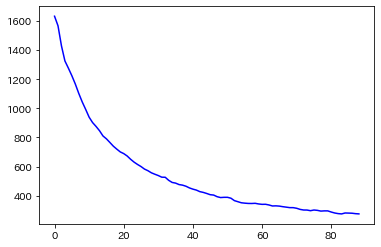

<Figure size 432x288 with 0 Axes>

In [12]:
# visualize loss 
loss = history.history['total_loss']
loss = loss[1:]
epochs = range(len(loss)) 
plt.plot(epochs, loss, 'b')
plt.figure()
plt.show()

In [13]:
sampler = Sampler()

In [14]:
# divide latent vectors into two classes kuzushiji & modern
kkanji_plot = np.zeros((kkanji_img_size, latent_dim)) 
mkanji_plot = np.zeros((mkanji_img_size, latent_dim))

z_mean, z_log_var = encoder.predict(x_train)
z = sampler(z_mean, z_log_var)
    
kkanji_count = 0
mkanji_count = 0

for i in range(0, img_size, 1):
    if int(y_row_train[i]) == 0:
        kkanji_plot[kkanji_count] = z[i]
        kkanji_count = kkanji_count + 1 
    elif int(y_row_train[i]) == 1:
        mkanji_plot[mkanji_count] = z[i]
        mkanji_count = mkanji_count + 1

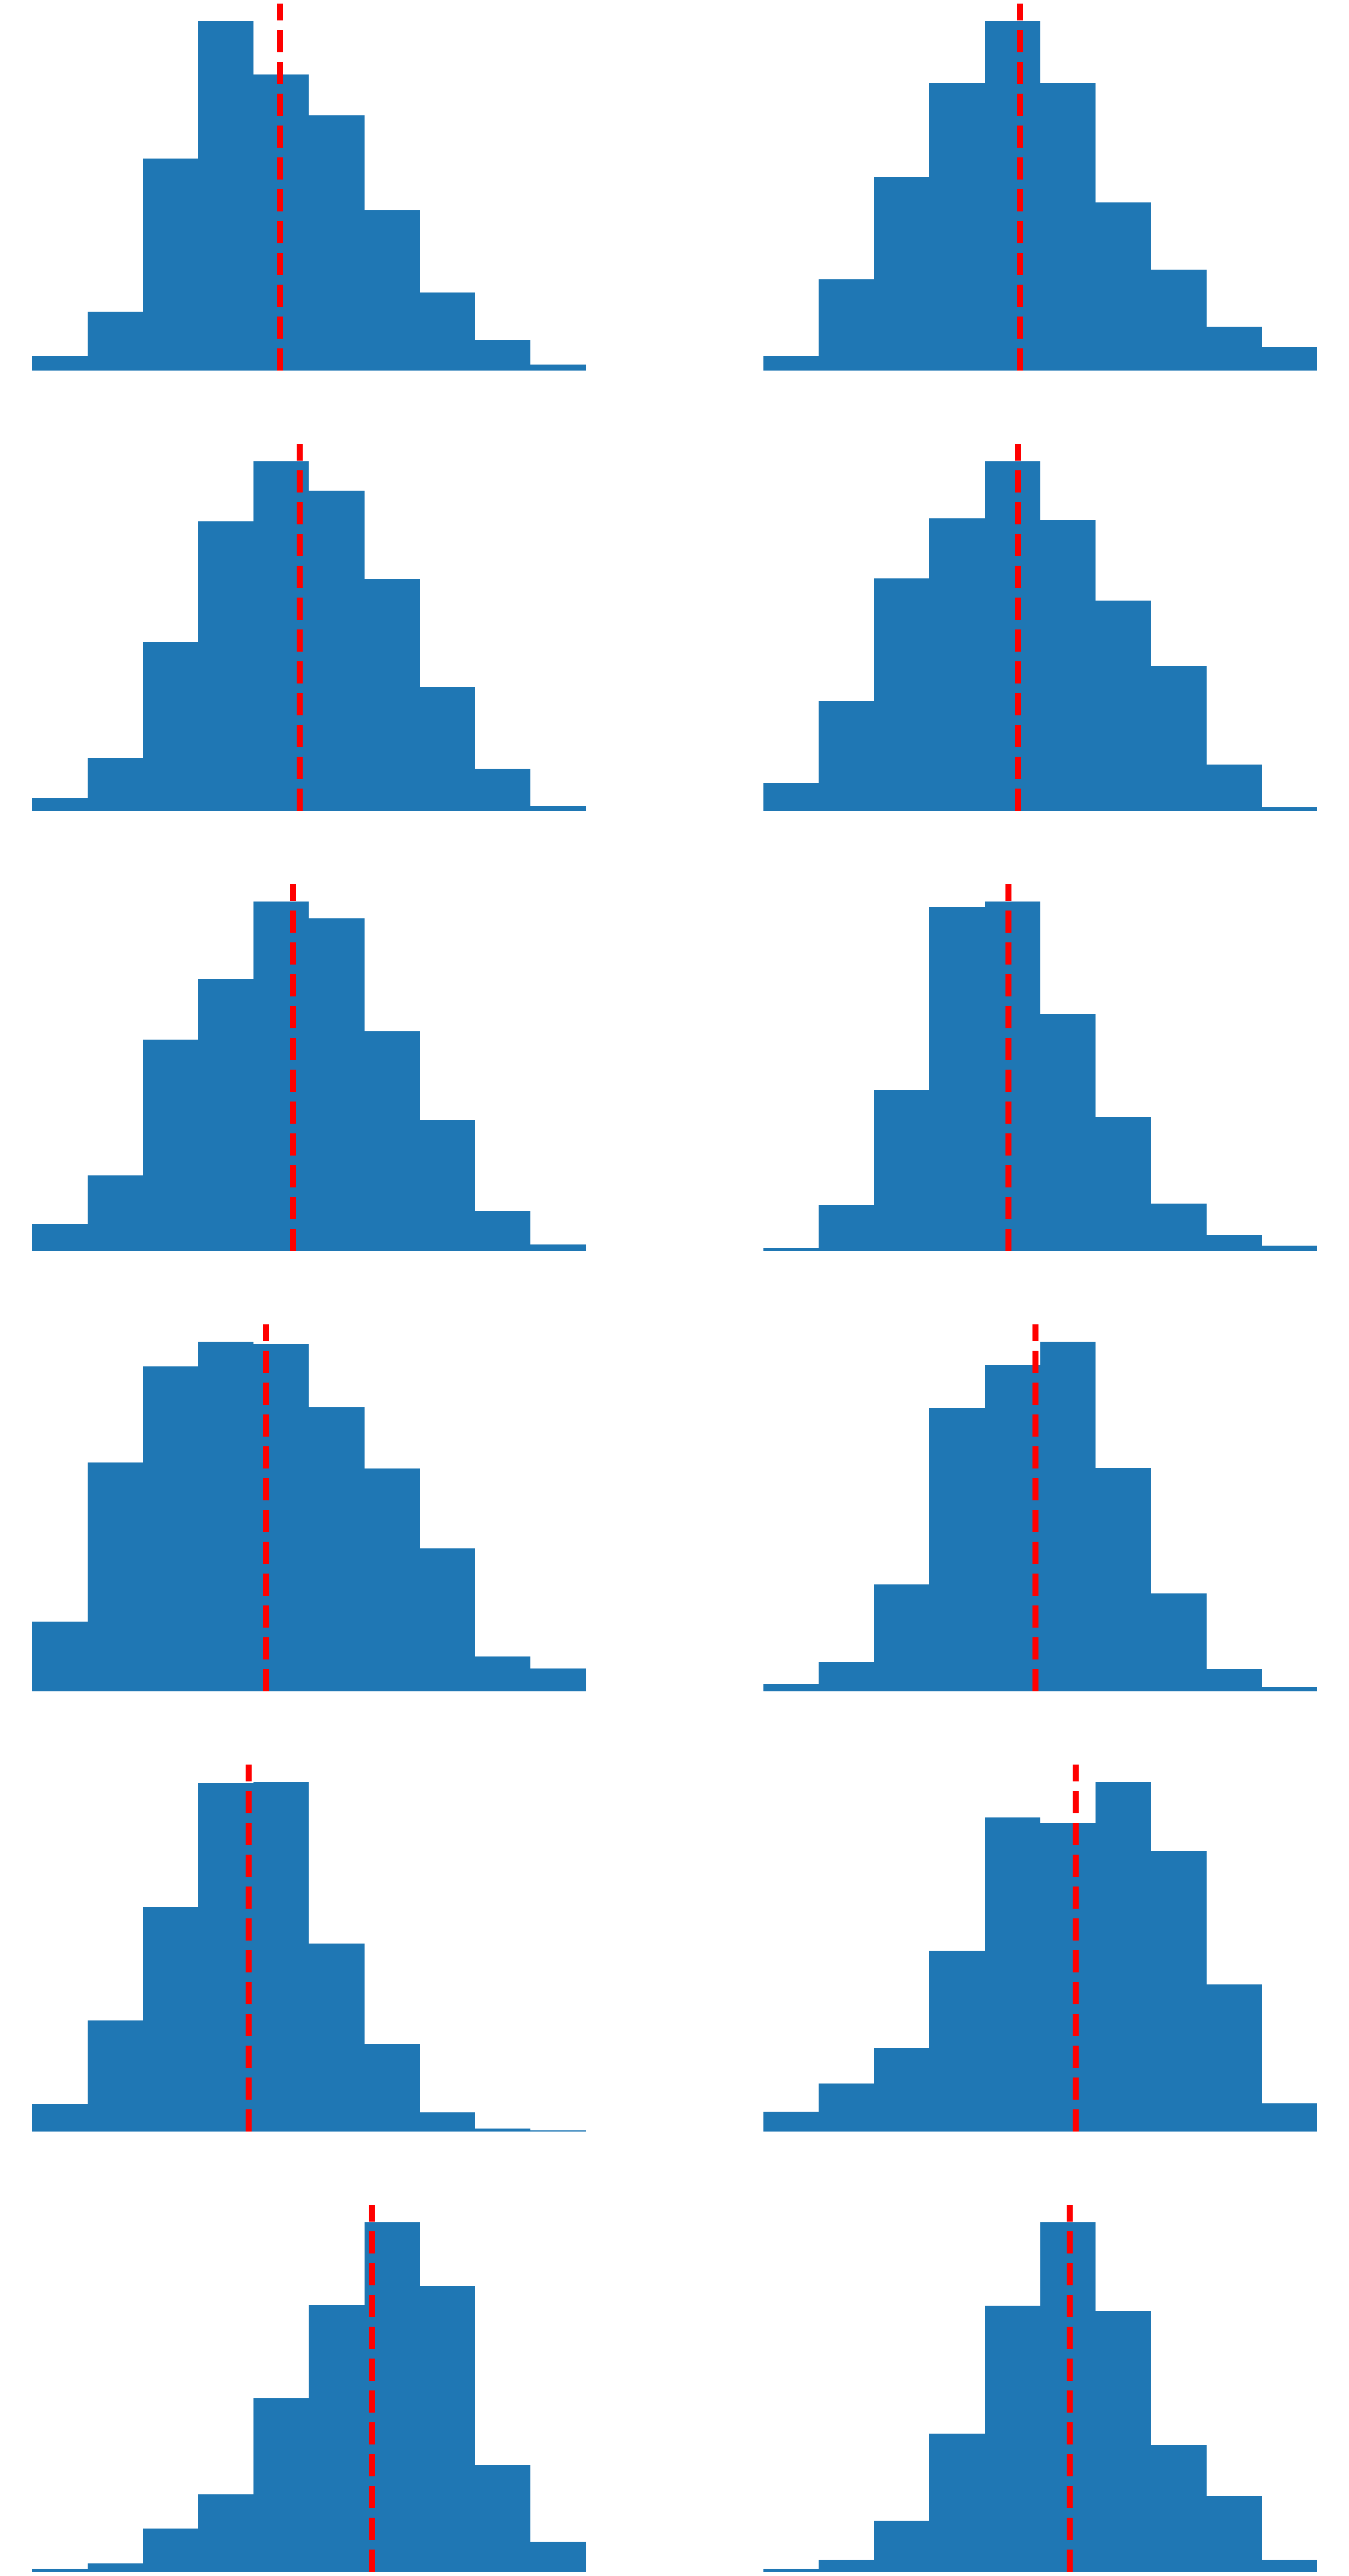

In [15]:
ss = preprocessing.StandardScaler()
z_standardization = ss.fit_transform(z)

# visualize latent vector
fig = plt.figure(figsize=(40,200))

if latent_dim > 12:
    loop = 12
else:
    loop = latent_dim
    
for i in range(0, loop, 1):
    l = np.array(z_standardization[:, i])
    plt.subplot(math.ceil(15), 2, i+1)
    plt.hist(l)
    plt.axis("off")
    plt.axvline(0, color='red', linestyle='dashed', linewidth=10)

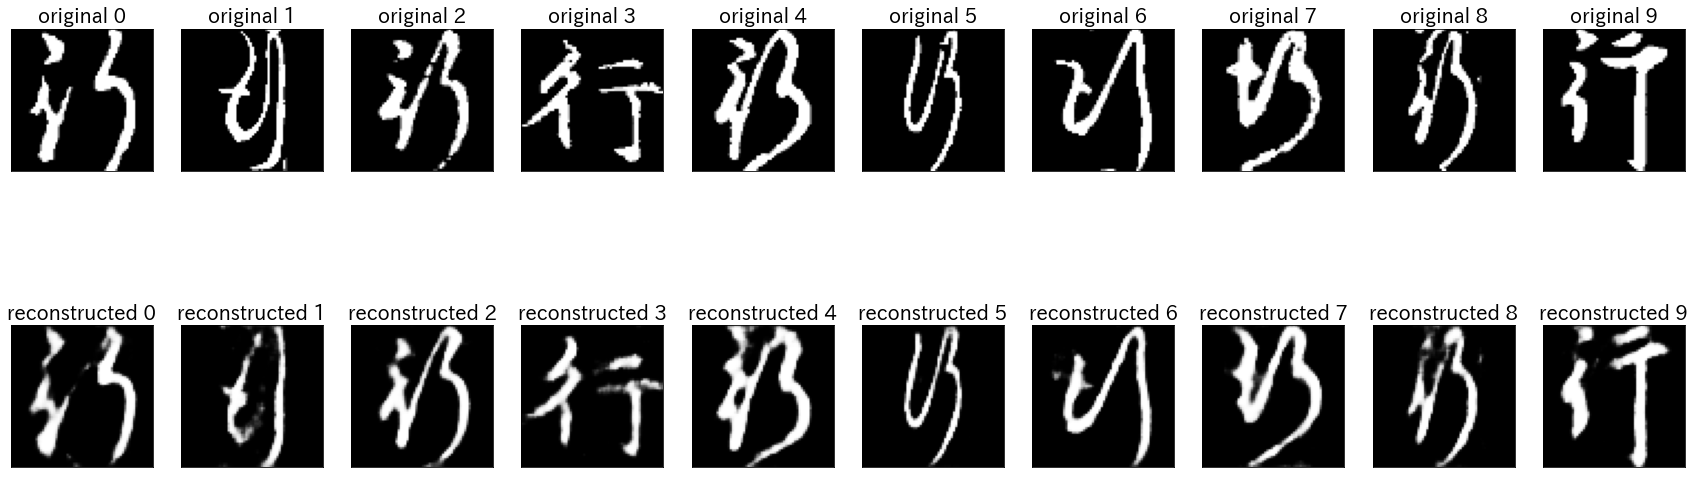

In [16]:
# test reconstruction by the model
fig, ax = plt.subplots(nrows = 2, ncols = k_val_print_size, figsize = (30,10))

for i in range(0, k_val_print_size, 1):
    img = cv2.imread(kkanji_imgs_test[i], 0)
    
    img = cv2.resize(img, (64, 64))
    cv2.imwrite('./outputs/' + str(i) + '.png', img)
    
    ax[0, i].set_title("original " + str(i), fontsize=20, color='black')
    ax[0, i].axes.xaxis.set_visible(False)
    ax[0, i].axes.yaxis.set_visible(False)
    ax[0, i].imshow(img,cmap=plt.cm.gray)
    
    img = img / 255.
    img = img.reshape((1, 64, 64, 1))
    img_encoded_mean, img_encoded_var = encoder.predict(img)
    img_encoded = sampler(img_encoded_mean, img_encoded_var)
    
    img_decoded = decoder.predict(img_encoded)
    img_decoded = img_decoded.reshape((64, 64))
    
    ax[1, i].set_title("reconstructed " + str(i), fontsize=20, color='black')
    ax[1, i].axes.xaxis.set_visible(False)
    ax[1, i].axes.yaxis.set_visible(False)
    ax[1, i].imshow(img_decoded,cmap=plt.cm.gray)

plt.show()

In [17]:
# furthermore devide kuzushiji into two, readable kuzushiji or not
modern_classification = load_model('./models/ETL_classification.h5')

etl_classes = glob.glob(mkanji_path + '/*')
etl_classes.sort()
results = np.zeros((kkanji_img_size, 3))
truth = 0

for i in range(0, 3036, 1):
    if jis_s in etl_classes[i]:
        truth = i

kkanji_decoded_gray = np.zeros((kkanji_img_size, 64, 64, 1))
kkanji_decoded_binary = np.zeros((kkanji_img_size, 64, 64, 1))

for i in range(kkanji_img_size):
    # decode as grayscale image
    img_encoded = kkanji_plot[i]
    img_encoded = img_encoded.reshape(1, latent_dim)
    img_decoded = decoder.predict(img_encoded)
    img_decoded_gray = img_decoded.reshape((64, 64, 1))
    
    # decode as binary image ..for recognition
    img_decoded_binary = img_decoded_gray * 255
    img_decoded_binary = np.uint8(img_decoded_binary)
    _, img_decoded_binary = cv2.threshold(img_decoded_binary, 0, 255, cv2.THRESH_OTSU)
    img_decoded_binary = img_decoded_binary / 255.
    img_decoded_binary = img_decoded_binary.reshape((64, 64, 1))
    
    # save the decoded images
    kkanji_decoded_gray[i] = img_decoded_gray
    kkanji_decoded_binary[i] = img_decoded_binary

# predict class
preds = modern_classification.predict(kkanji_decoded_binary)

# sort by the confidences (increase)
preds_sorted = np.argsort(preds, axis=1)
prediction_1st = preds_sorted[:, -1]

In [18]:
# visualize the results
prediction_visualize = []

for i in range(0, k_val_print_size + 1, 1):
    
    predicted_class = etl_classes[prediction_1st[i]][-4:]

    for k, kkanji_class in enumerate(kkanji_classes):
        
        for j in range(0, len(kkanji_class), 1):
            if kkanji_class[j] == 'U':
                u_index = j
                index = j + 2
        code = kkanji_class[index:]
        code = int(code, 16)
        code = chr(code)
        code = str(code)

        try:
            mkanji_class = (hex(code.encode("iso-2022-jp")[3])[2:] + hex(code.encode("iso-2022-jp")[4])[2:])
        except:
            mkanji_class = str(None)
        
        if k == 4327:
            prediction_visualize.append('None')
            
        if str(predicted_class) == str(mkanji_class):
            prediction_visualize.append(code)
            break   

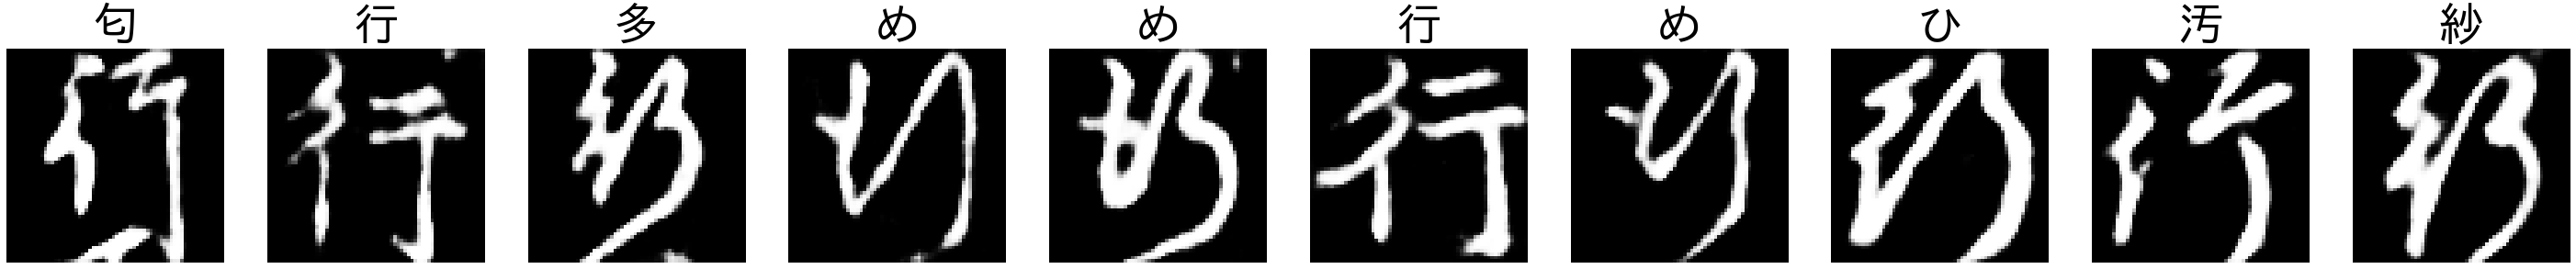

In [19]:
# visualize classes and input images
row = 1
col = k_val_print_size
fig = plt.figure(figsize=(50,10))

num = 0

while num < row * col:
    num = num + 1
    ax = plt.subplot(row, col, num)
    ax.set_title(str(prediction_visualize[num]), fontsize=50)
    plt.imshow(kkanji_decoded_gray[num][:-1], cmap=plt.cm.gray)
    plt.axis('off')

In [20]:
# divide readable & unreadable kuzushiji
readable_kuzushiji_count = 0
for i in range(0, kkanji_img_size, 1):
    if truth in preds_sorted[i][-allow_recognized:]:
        readable_kuzushiji_count = readable_kuzushiji_count + 1

unreadable_kuzushiji_count = kkanji_img_size - readable_kuzushiji_count

unreadable_kkanji_plot = np.zeros((unreadable_kuzushiji_count, latent_dim))
readable_kkanji_plot = np.zeros((readable_kuzushiji_count, latent_dim))

count_1 = 0
count_2 = 0
for i in range(0, kkanji_img_size, 1):
    if truth in preds_sorted[i][-allow_recognized:]:
        readable_kkanji_plot[count_1] = kkanji_plot[i]
        count_1 = count_1 + 1
    else :
        unreadable_kkanji_plot[count_2] = kkanji_plot[i]
        count_2 = count_2 + 1

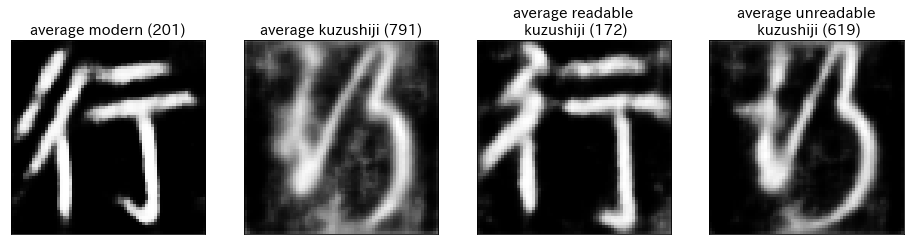

In [21]:
# average image of modern and kuzushiji and others...
mkanji_ave_point = np.average(mkanji_plot, axis = 0)
kkanji_ave_point = np.average(kkanji_plot, axis = 0)
readable_kkanji_ave_point = np.average(readable_kkanji_plot, axis = 0)
unreadable_kkanji_ave_point = np.average(unreadable_kkanji_plot, axis = 0)

ave_modern_decoded = decoder.predict(np.array([mkanji_ave_point]))
ave_modern_decoded = ave_modern_decoded.reshape((64, 64))

ave_kuzushiji_decoded = decoder.predict(np.array([kkanji_ave_point]))
ave_kuzushiji_decoded = ave_kuzushiji_decoded.reshape((64, 64))

ave_readable_kuzushiji_decoded = decoder.predict(np.array([readable_kkanji_ave_point]))
ave_readable_kuzushiji_decoded = ave_readable_kuzushiji_decoded.reshape((64, 64))

ave_unreadable_kuzushiji_decoded = decoder.predict(np.array([unreadable_kkanji_ave_point]))
ave_unreadable_kuzushiji_decoded = ave_unreadable_kuzushiji_decoded.reshape((64, 64))

fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(16,16))

ax[0].set_title("average modern (" + str(mkanji_img_size) + ")", fontsize=15, color='black')
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)
ax[0].imshow(ave_modern_decoded,cmap=plt.cm.gray)

ax[1].set_title("average kuzushiji (" + str(kkanji_img_size) + ")", fontsize=15, color='black')
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)
ax[1].imshow(ave_kuzushiji_decoded,cmap=plt.cm.gray)

ax[2].set_title("average readable\n kuzushiji (" + str(readable_kuzushiji_count) + ")", fontsize=15, color='black')
ax[2].axes.xaxis.set_visible(False)
ax[2].axes.yaxis.set_visible(False)
ax[2].imshow(ave_readable_kuzushiji_decoded,cmap=plt.cm.gray)

ax[3].set_title("average unreadable\n kuzushiji (" + str(unreadable_kuzushiji_count) + ")", fontsize=15, color='black')
ax[3].axes.xaxis.set_visible(False)
ax[3].axes.yaxis.set_visible(False)
ax[3].imshow(ave_unreadable_kuzushiji_decoded,cmap=plt.cm.gray)

In [22]:
if latent_dim == 2:
    labels = ['くずし字', '現代文字']
    plt.figure(figsize=(10, 10))
    plt.scatter(kkanji_plot[:, 0], kkanji_plot[:, 1], c = 'lightgreen')
    plt.scatter(mkanji_plot[:, 0], mkanji_plot[:, 1], c = 'yellow')

    kanji_data = np.concatenate([kkanji_plot, mkanji_plot])
    print(kanji_data.shape)

    for i in range(0, kkanji_img_size + mkanji_img_size, 1):
        x_max = np.max(kanji_data[:, 0])
        x_min = np.min(kanji_data[:, 0])
        y_max = np.max(kanji_data[:, 1])
        y_min = np.min(kanji_data[:, 1])

    plt.legend(labels, fontsize = 15)
    plt.show()

In [23]:
if latent_dim == 2:
    labels = ['読めるくずし字', '読めるくずし字平均', '読めないくずし字', '読めないくずし字平均', '現代文字', '現代文字平均', 'くずし字全体平均']
    plt.figure(figsize=(10, 10))
    plt.scatter(readable_kkanji_plot[:, 0], readable_kkanji_plot[:, 1], c = 'lightskyblue')
    plt.scatter(readable_kkanji_ave_point[0], readable_kkanji_ave_point[1], s = 100, c = 'blue')
    plt.scatter(unreadable_kkanji_plot[:, 0], unreadable_kkanji_plot[:, 1], c = 'lightgreen')
    plt.scatter(unreadable_kkanji_ave_point[0], unreadable_kkanji_ave_point[1], s = 100, c = 'green')
    plt.scatter(mkanji_plot[:, 0], mkanji_plot[:, 1], c = 'yellow')
    plt.scatter(mkanji_ave_point[0], mkanji_ave_point[1], s = 100, c = 'gold')
    plt.scatter(kkanji_ave_point[0], kkanji_ave_point[1], s = 100, c = 'gray')

    plt.legend(labels, fontsize = 15)
    plt.show()

In [24]:
if latent_dim == 2:
    labels = ['読めるくずし字', '読めないくずし字', '読めないくずし字平均', '現代文字', '現代文字平均', 'くずし字全体平均',  '読めるくずし字平均']
    plt.figure(figsize=(10, 10))
    plt.scatter(readable_kkanji_plot[:, 0], readable_kkanji_plot[:, 1], c = 'lightskyblue')
    plt.scatter(unreadable_kkanji_plot[:, 0], unreadable_kkanji_plot[:, 1], c = 'lightgreen')
    plt.scatter(unreadable_kkanji_ave_point[0], unreadable_kkanji_ave_point[1], s = 100, c = 'green')
    plt.scatter(mkanji_plot[:, 0], mkanji_plot[:, 1], c = 'yellow')
    plt.scatter(mkanji_ave_point[0], mkanji_ave_point[1], s = 100, c = 'gold')
    plt.scatter(kkanji_ave_point[0], kkanji_ave_point[1], s = 100, c = 'gray')
    plt.scatter(readable_kkanji_ave_point[0], readable_kkanji_ave_point[1], s = 100, c = 'blue')
    
    plt.legend(labels, fontsize = 15)
    plt.show()

In [25]:
if latent_dim == 2:
    #visualize latent space
    n = 32
    digit_size = 64
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(x_min, x_max, n)
    grid_y = np.linspace(y_min, y_max, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    
    plt.imshow(figure, cmap="Greys_r")

In [26]:
# save images to numpy
imgs_original = np.zeros((k_val_size, 64, 64))
imgs_decoded = np.zeros((k_val_size, 3 * interval, 64, 64))
imgs_decoded_confidence = np.zeros((k_val_size, 3 * interval))
imgs_decoded_classification = np.zeros((k_val_size, 3 * interval))

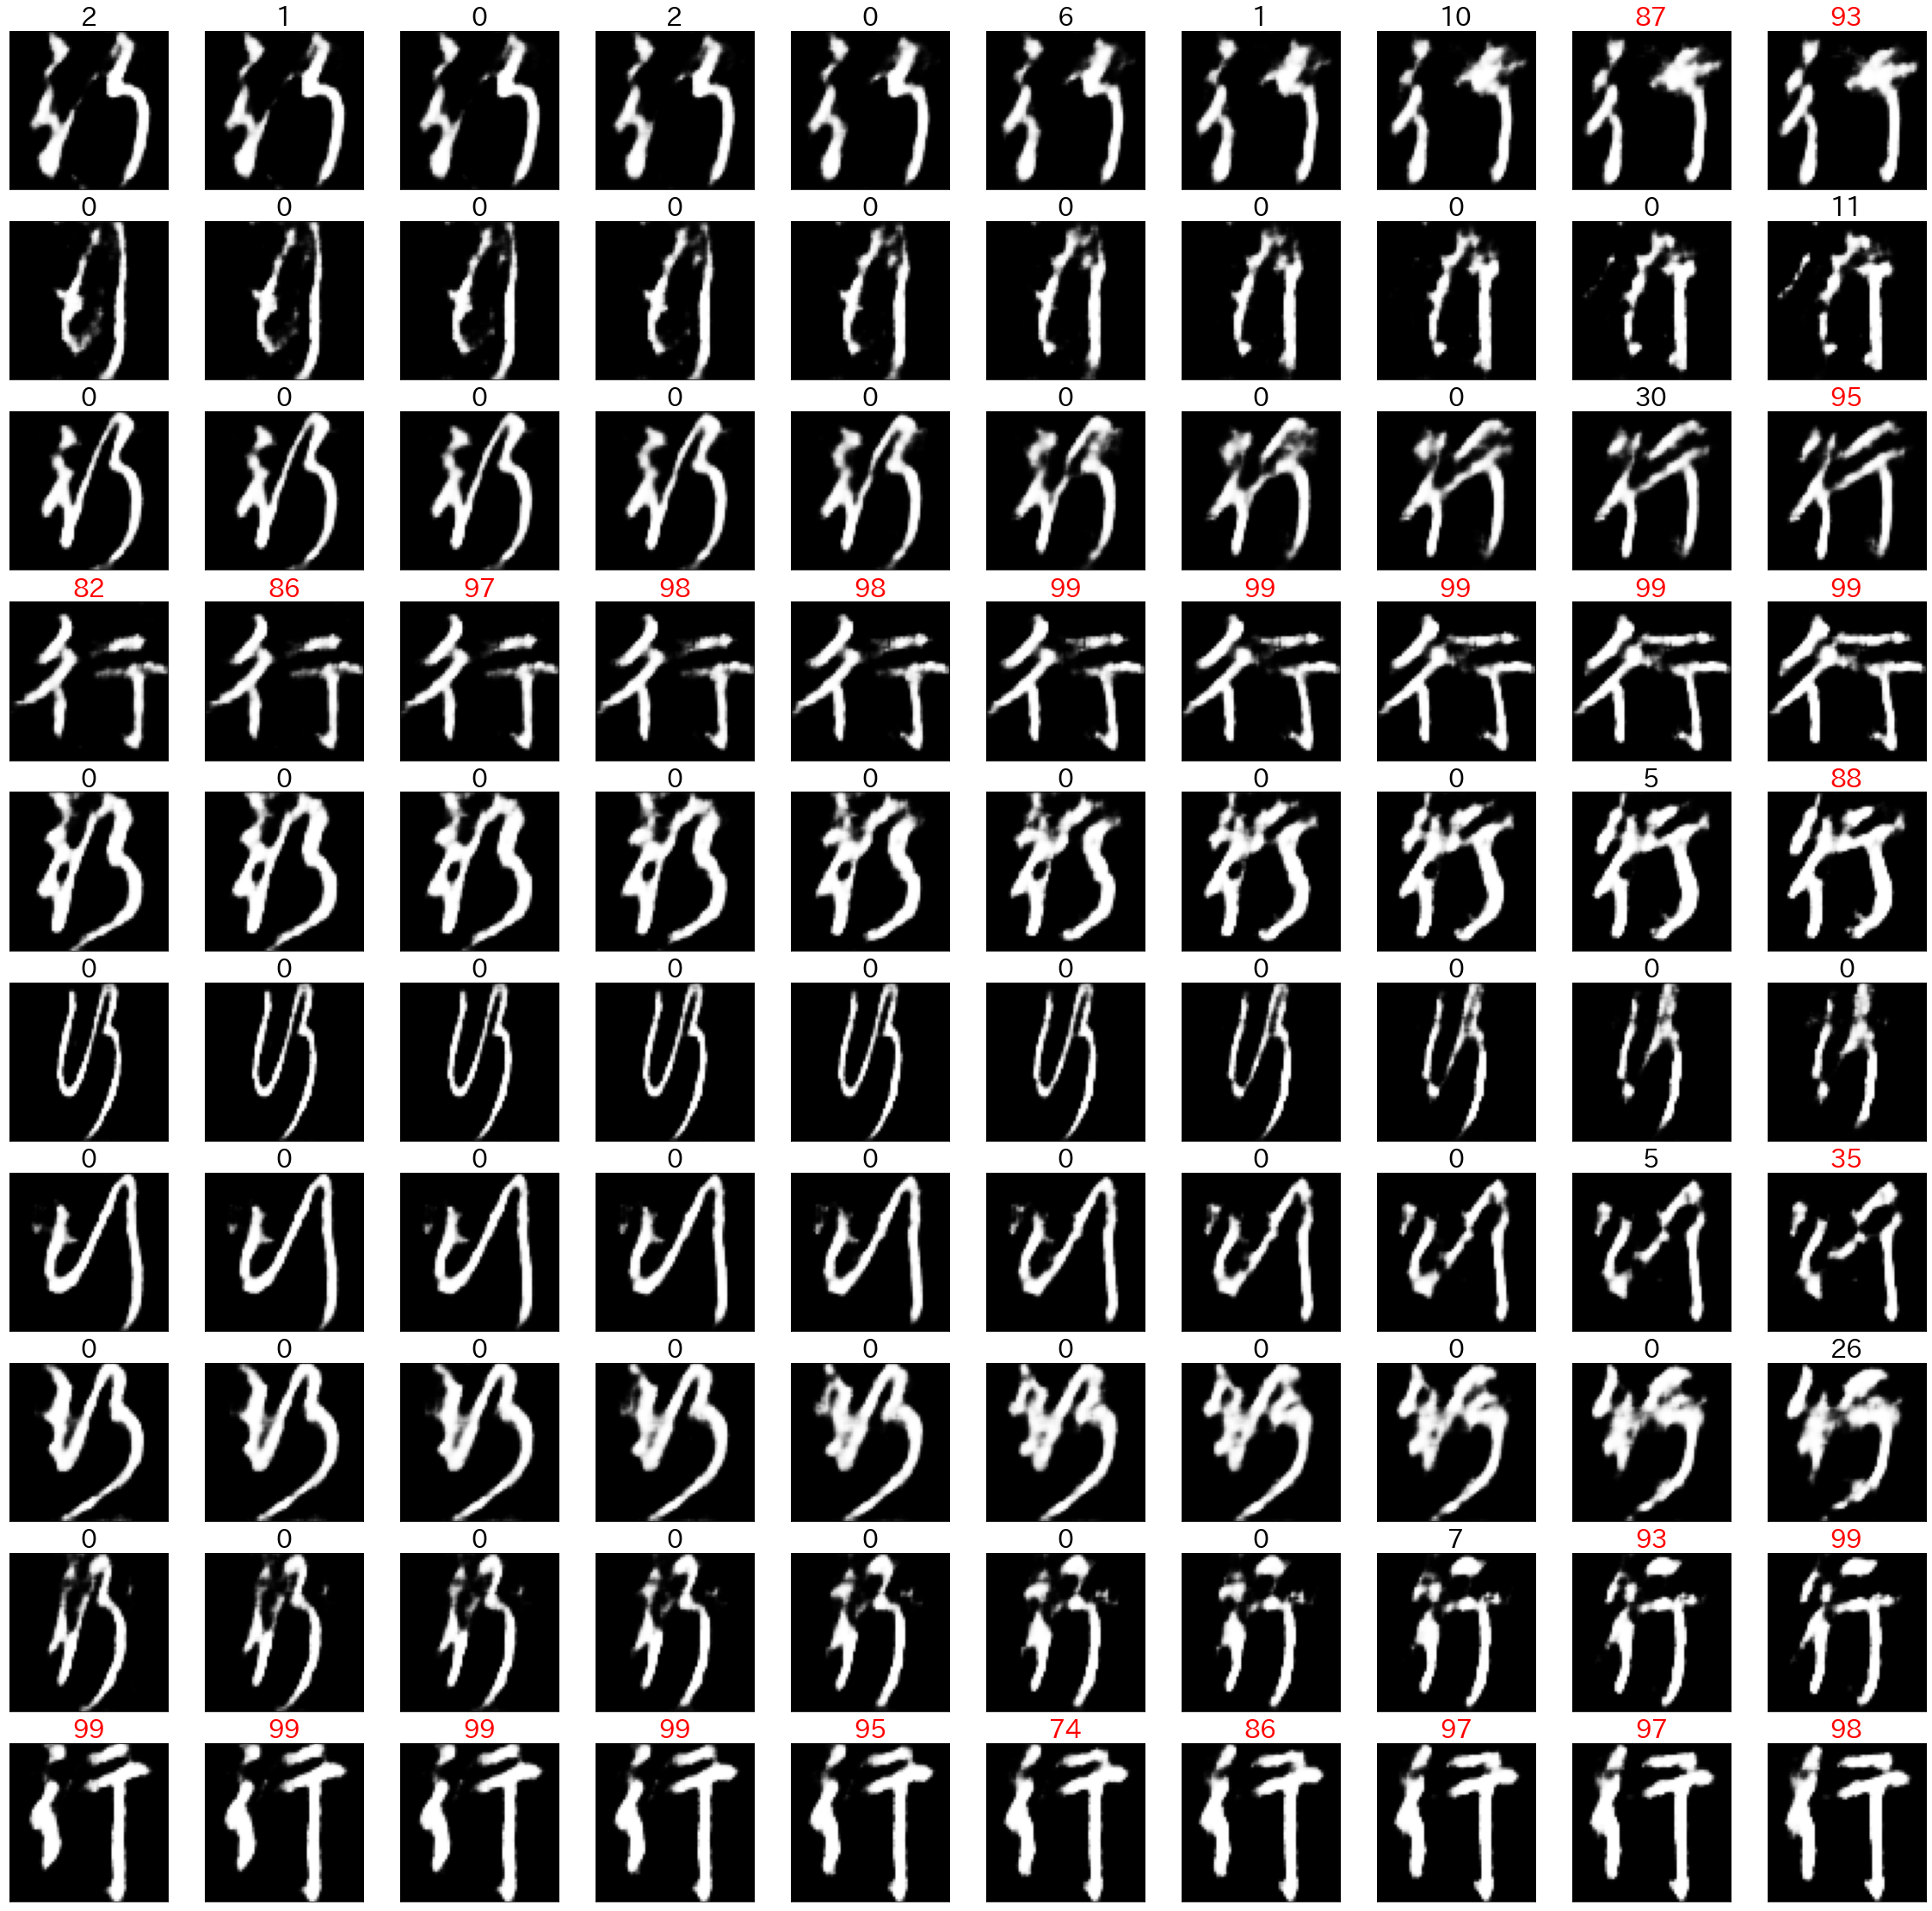

In [27]:
# modern - kuzushiji
fig, ax = plt.subplots(nrows = k_val_print_size, ncols = interval,figsize = (40,40))

for i in range(0, k_val_print_size, 1):
    # pre process
    img = cv2.imread(kkanji_imgs_test[i], 0)    
    img_original = cv2.resize(img, (64, 64))
    img = img_original / 255.
    img = img.reshape((1, 64, 64, 1))
    imgs_original[i] = img_original # save

    # encode
    img_encoded_mean, img_encoded_var = encoder.predict(img)
    img_encoded = sampler(img_encoded_mean, img_encoded_var)
    
    feature_vector = mkanji_ave_point - kkanji_ave_point
    alpha = 0.
        
    for j in range(0, interval, 1):
        
        target_img = img_encoded + (alpha * feature_vector)
        
        # decode
        img_decoded = decoder.predict(target_img)
        img_decoded = img_decoded.reshape((64, 64))
        imgs_decoded[i, 2 * interval + j] = img_decoded # save 
        
        # change to binary
        img_decoded_binary = img_decoded * 255.
        img_decoded_binary = np.uint8(img_decoded_binary)
        _, img_decoded_binary = cv2.threshold(img_decoded_binary, 0, 255, cv2.THRESH_OTSU)
        img_decoded_binary = img_decoded_binary / 255.
        img_decoded_binary_predict = img_decoded_binary.reshape((1, 64, 64, 1))
        
        # recognition decoded image
        predicted = modern_classification.predict(img_decoded_binary_predict)
        predicted_class = np.argmax(predicted)
        predicted_conf = int(predicted[:, truth]*100)
        imgs_decoded_confidence[i, 2 * interval + j] = predicted_conf # save
        

        if predicted_class == truth:
            color = 'red'
            imgs_decoded_classification[i, 2 * interval + j] = True
        else:
            color = 'black'
            imgs_decoded_classification[i, 2 * interval + j] = False
            

        # print outputs
        ax[i, j].set_title(str(predicted_conf), fontsize=30, color=color)
        ax[i, j].axes.xaxis.set_visible(False)
        ax[i, j].axes.yaxis.set_visible(False)
        ax[i, j].imshow(img_decoded,cmap=plt.cm.gray)
        
        alpha = alpha + (1. / (interval-1))

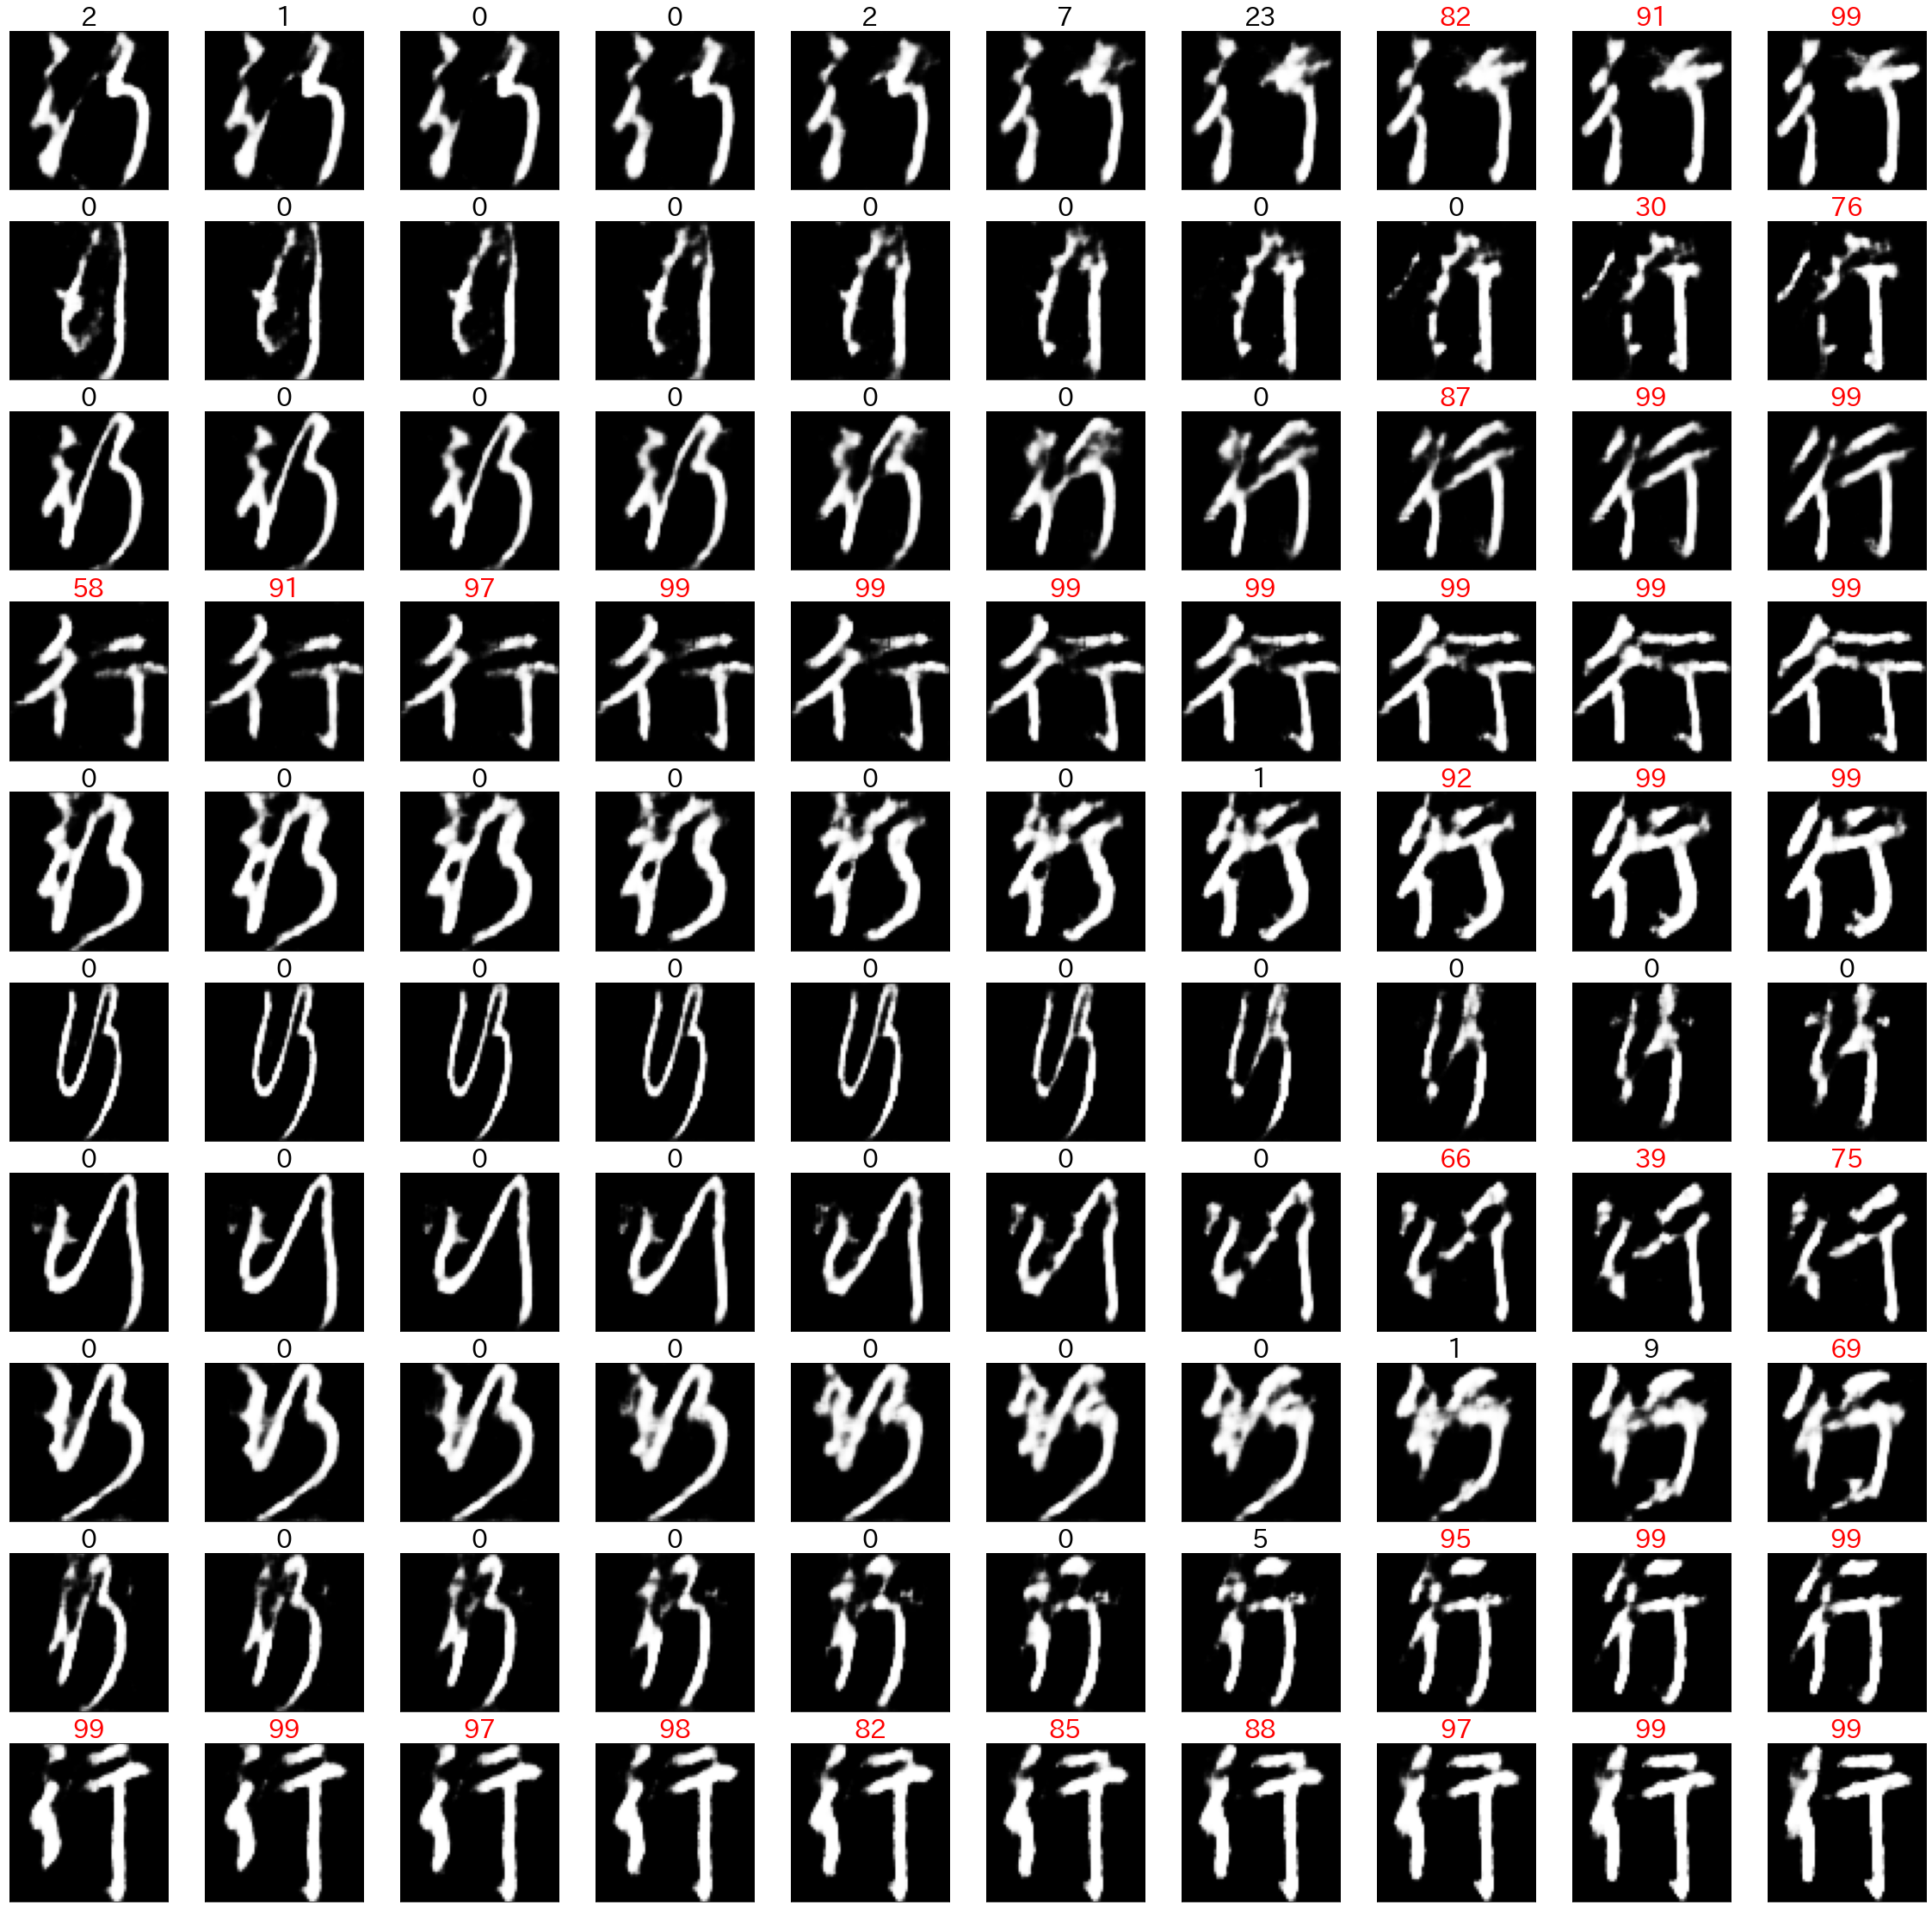

In [28]:
# modern - unreadable_kuzushiji
fig, ax = plt.subplots(nrows = k_val_print_size, ncols = interval,figsize = (40,40))

for i in range(0, k_val_print_size, 1):
    # pre process
    img = cv2.imread(kkanji_imgs_test[i], 0)    
    img_original = cv2.resize(img, (64, 64))
    img = img_original / 255.
    img = img.reshape((1, 64, 64, 1))
    
    # encode
    img_encoded_mean, img_encoded_var = encoder.predict(img)
    img_encoded = sampler(img_encoded_mean, img_encoded_var)
    
    feature_vector = mkanji_ave_point - unreadable_kkanji_ave_point
    alpha = 0.
        
    for j in range(0, interval, 1):
        
        target_img = img_encoded + (alpha * feature_vector)
        
        # decode
        img_decoded = decoder.predict(target_img)
        img_decoded = img_decoded.reshape((64, 64))
        imgs_decoded[i, 1 * interval + j] = img_decoded # save 
        
        # change to binary
        img_decoded_binary = img_decoded * 255.
        img_decoded_binary = np.uint8(img_decoded_binary)
        _, img_decoded_binary = cv2.threshold(img_decoded_binary, 0, 255, cv2.THRESH_OTSU)
        img_decoded_binary = img_decoded_binary / 255.
        img_decoded_binary_predict = img_decoded_binary.reshape((1, 64, 64, 1))
        
        # recognition decoded image
        predicted = modern_classification.predict(img_decoded_binary_predict)
        predicted_class = np.argmax(predicted)
        predicted_conf = int(predicted[:, truth]*100)
        imgs_decoded_confidence[i, 1 * interval + j] = predicted_conf # save

        if predicted_class == truth:
            color = 'red'
            imgs_decoded_classification[i, 1 * interval + j] = True
        else:
            color = 'black'
            imgs_decoded_classification[i, 1 * interval + j] = False

        # print outputs
        ax[i, j].set_title(str(predicted_conf), fontsize=30, color=color)
        ax[i, j].axes.xaxis.set_visible(False)
        ax[i, j].axes.yaxis.set_visible(False)
        ax[i, j].imshow(img_decoded,cmap=plt.cm.gray)
        
        alpha = alpha + (1. / (interval-1))

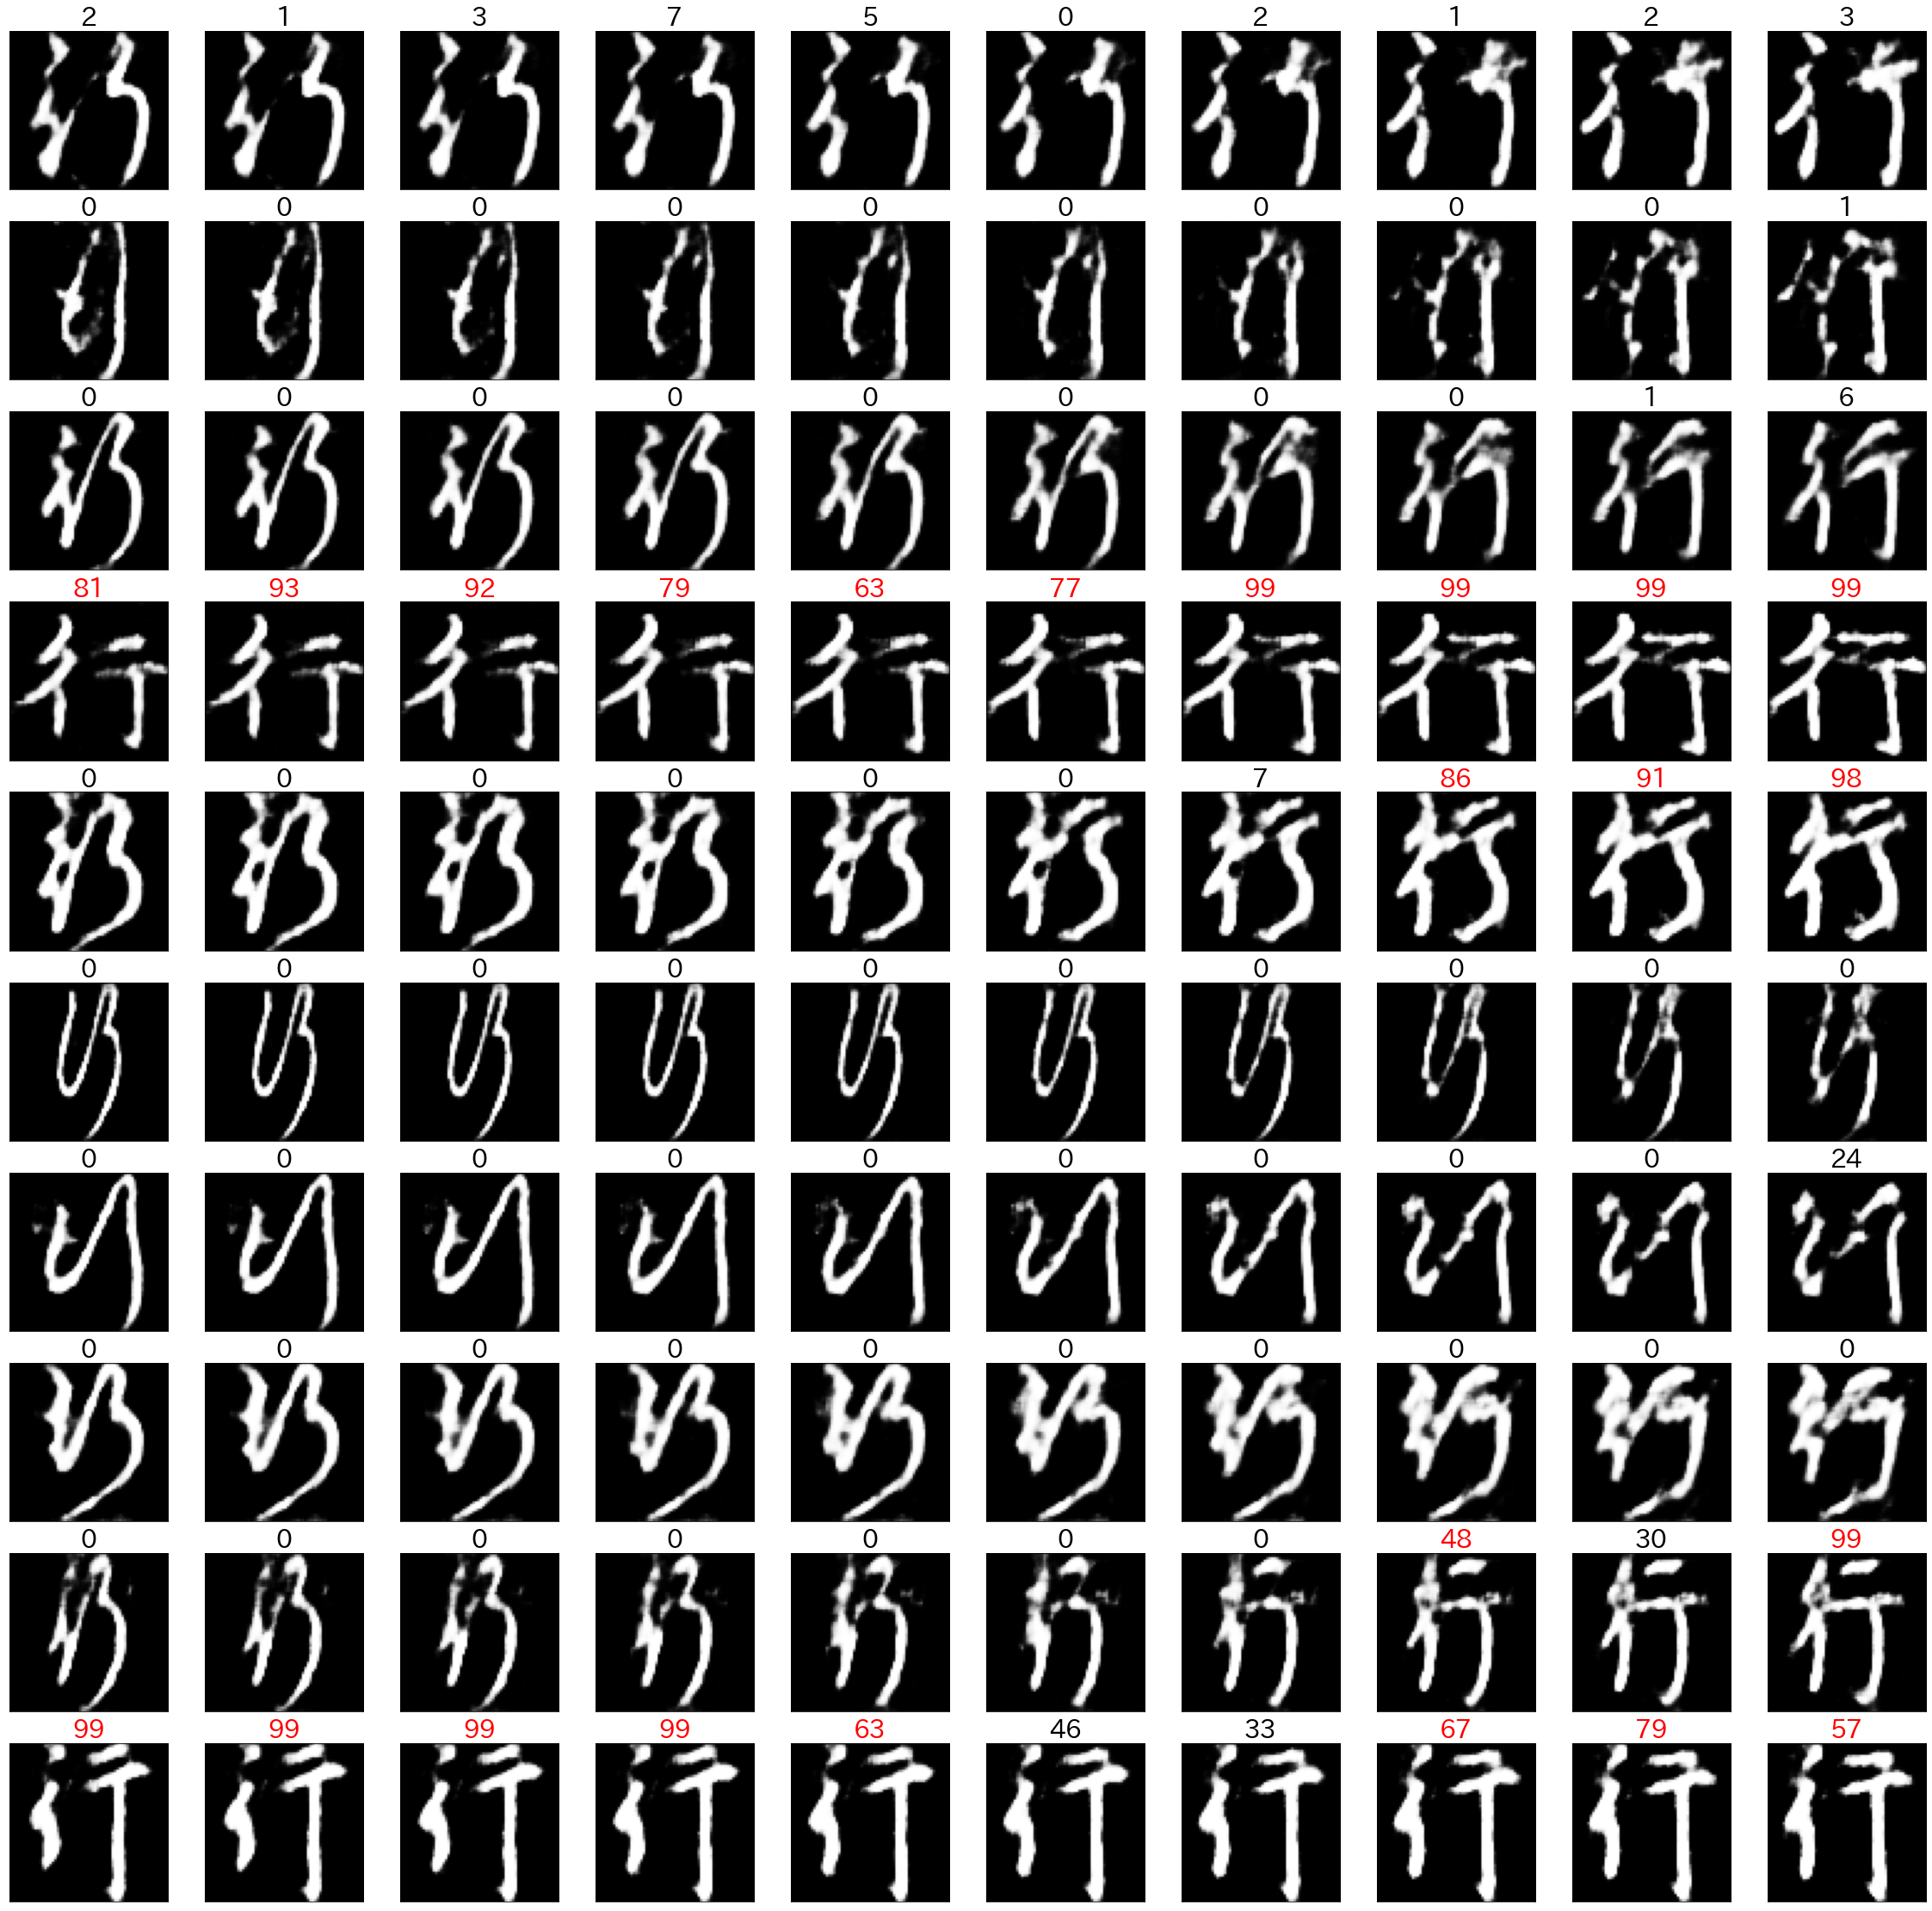

In [29]:
# readable_kuzushiji - unreadable_kuzushiji
fig, ax = plt.subplots(nrows = k_val_print_size, ncols = interval,figsize = (40,40))

for i in range(0, k_val_print_size, 1):
    # pre process
    img = cv2.imread(kkanji_imgs_test[i], 0)    
    img_original = cv2.resize(img, (64, 64))
    img = img_original / 255.
    img = img.reshape((1, 64, 64, 1))
    
    # encode
    img_encoded_mean, img_encoded_var = encoder.predict(img)
    img_encoded = sampler(img_encoded_mean, img_encoded_var)
        
    feature_vector = readable_kkanji_ave_point - unreadable_kkanji_ave_point
    alpha = 0.
        
    for j in range(0, interval, 1):
        
        target_img = img_encoded + (alpha * feature_vector)
        
        # decode
        img_decoded = decoder.predict(target_img)
        img_decoded = img_decoded.reshape((64, 64))
        imgs_decoded[i, 0 * interval + j] = img_decoded # save 
        
        # change to binary
        img_decoded_binary = img_decoded * 255.
        img_decoded_binary = np.uint8(img_decoded_binary)
        _, img_decoded_binary = cv2.threshold(img_decoded_binary, 0, 255, cv2.THRESH_OTSU)
        img_decoded_binary = img_decoded_binary / 255.
        img_decoded_binary_predict = img_decoded_binary.reshape((1, 64, 64, 1))
        
        # recognition decoded image
        predicted = modern_classification.predict(img_decoded_binary_predict)
        predicted_class = np.argmax(predicted)
        predicted_conf = int(predicted[:, truth]*100)
        imgs_decoded_confidence[i, 0 * interval + j] = predicted_conf # save

        if predicted_class == truth:
            color = 'red'
            imgs_decoded_classification[i, 0 * interval + j] = True
        else:
            color = 'black'
            imgs_decoded_classification[i, 0 * interval + j] = False

        # print outputs
        ax[i, j].set_title(str(predicted_conf), fontsize=30, color=color)
        ax[i, j].axes.xaxis.set_visible(False)
        ax[i, j].axes.yaxis.set_visible(False)
        ax[i, j].imshow(img_decoded,cmap=plt.cm.gray)
        
        alpha = alpha + (1. / (interval-1))

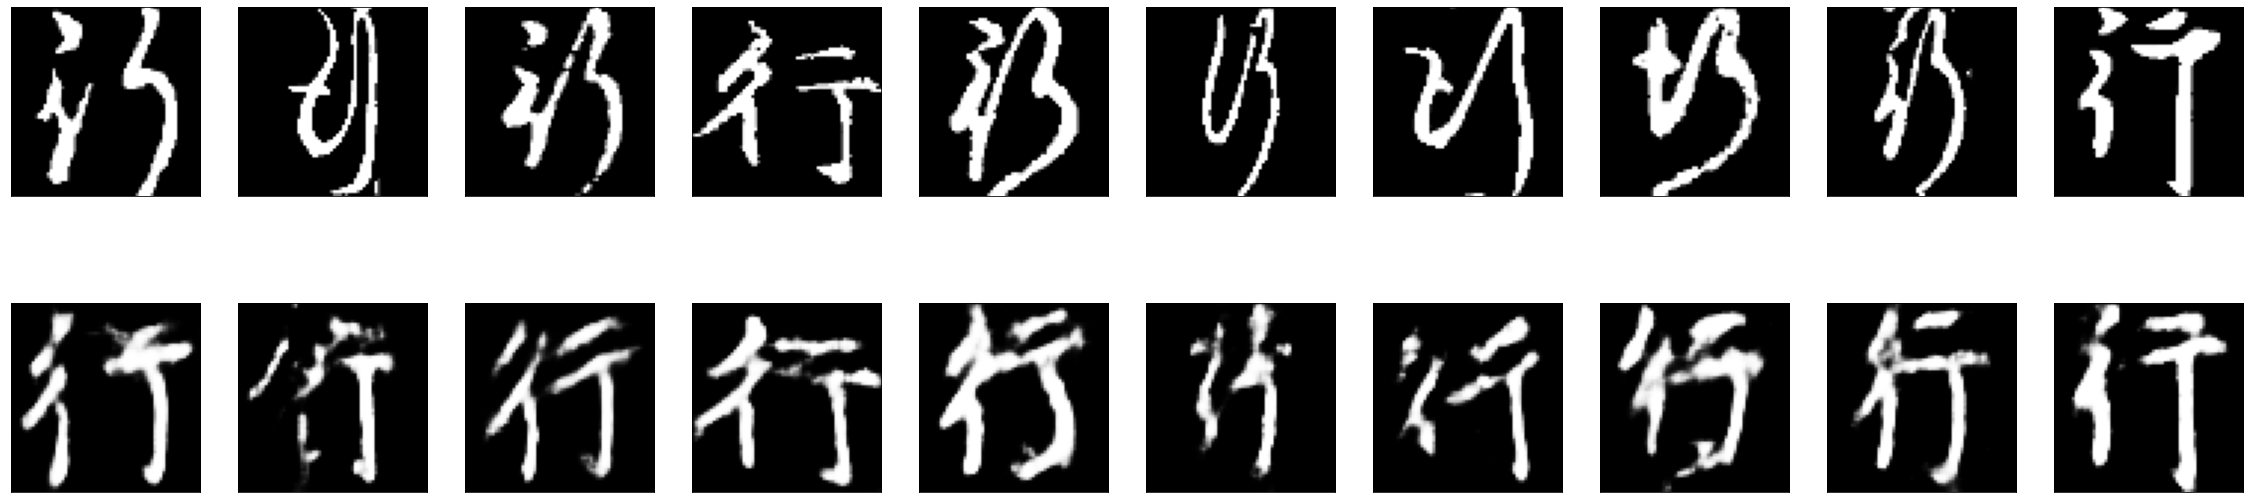

In [30]:
# print
fig, ax = plt.subplots(nrows = 2, ncols = k_val_print_size, figsize = (40, 10))

for i in range(0, k_val_print_size, 1):
    ax[0, i].axes.xaxis.set_visible(False)
    ax[0, i].axes.yaxis.set_visible(False)
    ax[0, i].imshow(imgs_original[i], cmap=plt.cm.gray)

for i in range(0, k_val_print_size, 1): 
    index_1 = interval - 1
    index_2 = 2 * interval - 1
    index_3 = 3 * interval - 1
    
    #else:
    if imgs_decoded_classification[i, index_1] == True:
        index = index_1
    else:
        if imgs_decoded_classification[i, index_2] == True:
            index = index_2
        else:
            if imgs_decoded_classification[i, index_3] == True:
                index = index_3
            else:
                index = index_2

    out_img = imgs_decoded[i, index]

    os.makedirs('./outputs/' + str(s), exist_ok = True)
    already_exists = glob.glob('./outputs/' + str(s) + '/*')
    save_index = int(len(already_exists)/2)
    
    plt.imsave('./outputs/' + str(s) + '/' + str(save_index) + '.png', imgs_original[i], cmap = plt.cm.gray)
    plt.imsave('./outputs/' + str(s) + '/' + str(save_index) + '_out.png', out_img, cmap = plt.cm.gray)

    ax[1, i].axes.xaxis.set_visible(False)
    ax[1, i].axes.yaxis.set_visible(False)
    ax[1, i].imshow(out_img, cmap=plt.cm.gray)